# Two-variables Optimization of the CRM-like Box Beam

In our [last notebook](19_One-variable_Optimization_of_the_CRM-like_Box_Beam.ipynb) we performed a simple structural optimization of the CRM-like box beam using a nonlinear structural stability constraint based on monitoring the smallest-magnitude eigenvalues of the tangent stiffness matrix. We used a single design variable, corresponding to a uniform thickness over all the elements of the structure, and we found a 11.3% mass reduction with respect to the initial design, which was optimal in linear buckling terms.

In this notebook we want to go a step further and perform an optimization with a varying thickness over the length of the CRM-like box beam.

* [Definition of the box beam model](#model-definition)
* [Formulation of the optimization problem](#optimization-problem)
* [OpenMDAO implementation](#openmdao-implementation)
* [Setup of the numerical model](#numerical-model-setup)
* [First optimization](#first-optimization)
* [Second optimization](#second-optimization)
* [Conclusion](#conclusion)

## Definition of the box beam model <a name="model-definition"></a>

***

We recall the geometrical parameters that we derived in [notebook 18](18_Development_and_Nonlinear_Buckling_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb).

In [1]:
import numpy as np  # import numpy library

l = 29.38e3  # [mm] box beam length
w = 3.41e3  # [mm] box beam width
h = 0.77e3  # [mm] box beam height
t0 = h/100  # [mm] initial box beam thickness
stiffeners_height = h/10  # [mm] stiffeners height
no_stiffeners = 2  # number of stiffeners
stiffeners_x_locations = np.linspace(0, w, no_stiffeners + 2)[1:-1]  # [mm] stiffeners x-coordinates
stiffeners_spacing = w/(no_stiffeners + 1)  # [mm] stiffeners spacing
ribs_spacing = stiffeners_spacing*1.4 # [mm] ribs spacing
no_ribs = round(l/ribs_spacing) + 1  # number of ribs
ribs_y_locations = np.linspace(0, l, no_ribs)  # [mm] ribs y-coordinates
print(f"Number of stiffeners: {no_stiffeners:d}\nNumber of ribs: {no_ribs:d}")  # print number of stiffeners and ribs

Number of stiffeners: 2
Number of ribs: 19


We also recall the converged quadrilateral element length that we'll use to define our mesh.

In [2]:
element_length = 169.6  # [mm]

Then we recall the material properties. This time we also consider the yield strength, always taking it from the paper by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603).

In [3]:
rho = 2780e-12  # density [tons/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio
SIGMA_Y = 420.  # yield strength [MPa]

## Formulation of the optimization problem <a name="optimization-problem"></a>

***

We need to perform a baseline optimization and we do this by imposing linear buckling and elastic deformation constraints.

Let's recall the linear buckling load of the CRM-like box beam that we found in our [last notebook](18_Development_and_Nonlinear_Buckling_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb#mesh-convergence).

In [4]:
design_load = 12517.  # [N]

Now we need to define the constraints of our optimization. We will use the following constraints:

- the buckling load factor must be greater than 1;
- all deformations must be elastic, i.e. the structure must not yield.

The first constraint corresponds to the linear structural stability constraint, and we are going to enforce it by constraining the lowest $N_{BLF}$ buckling load factors returned by the linear analysis. The second constraint corresponds to a more traditional strength constraint, and we are going to enforce it by constraining the von Mises stress of all elements to be below the yield strength.

Our optimization problem can then be stated as it follows:
$$
    \begin{aligned}
        & \text{minimize :} & & m\\
        & \text{w.r.t. :} & & t\\
        & \text{subject to :} & & g_{BLF,i}=1-BLF_i<0,\; i=1, \dots, N_{BLF}\\
        & & & g_{\sigma, j}=\sigma_k-\sigma_{max}<0,\; j=1, \dots, N_e\\
        & & & t_{min} \leq t \leq t_{max},
    \end{aligned}
$$

where $BLF_i$ is the $i$-th buckling load factor, $\sigma_j$ is the von Mises stress of the $j$-th element, $\sigma_{max}$ is the yield strength and $t_{min}$ and $t_{max}$ are the thickness bounds.

Instead of imposing the constraints on each eigenvalue and on each element, we are going to aggregate them using Kreisselmeier–Steinhauser (KS) functions ([Martins & Ning, 2021](https://www.cambridge.org/highereducation/books/engineering-design-optimization/B1B23D00AF79E45502C4649A0E43135B#contents)), so that we have one single value for the nonlinear structural stability constraint and one single value for the strength constraint:

$$g_{KS_{BLF}}=\max_i\left(g_{BLF,i}\right)+\frac{1}{\rho}\ln\left(\sum_{i=1}^{N_i}\exp\left(\rho\left(g_{BLF,i}-\max_i\left(g_{BLF,i}\right)\right)\right)\right),$$
$$g_{KS_\sigma}=\max_k\left(\sigma_k-\sigma_{max}\right)+\frac{1}{\rho}\ln\left(\sum_{k=1}^{N_e}\exp\left(\rho\left(\sigma_k-\sigma_{max}-\max_k\left(\sigma_k-\sigma_{max}\right)\right)\right)\right).$$

## OpenMDAO implementation <a name="openmdao-implementation"></a>

***

To implement our optimization, we are going to use the open-source high-performance computing platform of [OpenMDAO](https://openmdao.org/). The smallest unit of computational work within OpenMDAO is the so-called Component, where the actual numerical calculations happen. Each component has input and output variables that can be connected to chain together multiple computations. In our case, we only have one kind of computation happening, that is to say the nonlinear analysis under the design load. This computation has to take as input the wall thickness of our box beam, which is our only design variable, and calculate our objective and constraints.

Let's go on with defining this component, which we'll call `Sol105Comp`, as we are going to use Nastran SOL 105 to perform the linear buckling analysis. We define the component such that it takes as option a `BDF` object, representing the Nastran model, and as input the wall thickness of the box beam. The options represent "static inputs" of the component, defining quantities or objects that do not change during the optimization, while the inputs represent "dynamic inputs", corresponding to the design variables. Since our only design variable is the wall thickness of the box beam and the rest of the structural model remains unchanged, we pass the `BDF` object to the component as an option, while the wall thickness is passed as an input. The component then changes the thickness property of the `PSHELL` card in the `BDF` object, calculates the box beam's mass, runs the linear buckling analysis and calculates the constraints value. Mass and constraints are defined as outputs of the component.

In [5]:
import openmdao.api as om  # make available the most common OpenMDAO classes and functions
from pyNastran.bdf.bdf import BDF  # pyNastran BDF class
import os  # library for file path operations
from resources import pynastran_utils  # utility functions to work with pyNastran objects
from pyNastran.bdf.mesh_utils.mass_properties import mass_properties  # pyNastran function to calculate mass properties


FORCE_SET_ID = 11  # FORCE card id
METHOD_SET_ID = 21  # method set id for SOL 106
NO_EIGENVALUES = 20  # number of tangent stiffness matrix eigenvalues to calculate for each converged iteration
ANALYSIS_DIRECTORY_PATH = os.path.join(os.getcwd(), 'analyses', '20_Two-variables_Optimization_of_the_CRM-like_Box_Beam')  # path to analysis directory
FIRST_SUBCASE_ID = 1  # id of first subcase for SOL 106
SECOND_SUBCASE_ID = 2  # id of second subcase for SOL 106
Z_AXIS_INDEX = 2  # index of z-axis in displacements and loads array
SOL_105_INPUT_NAME = 'linear_opt_sol_105'  # default name of the bdf file for the analysis
 

class Sol105Comp(om.ExplicitComponent):
    """
    A component for evaluating the objective and constraints value of the box beam model using SOL 105.

    This component takes as input the wall thickness of the box beam and evaluates the mass of the model.
    It also calculates the value of the linear buckling and of the strength constraint.

    Attributes
    ----------
    options : dict
        A dictionary of options for the component.

    Methods
    -------
    initialize()
        Declare options for the component.
    setup()
        Define the component's inputs and outputs.
    setup_partials()
        Declare partial derivatives for the component.
    compute(inputs, outputs, discrete_inputs, discrete_outputs)
        Run SOL 106 and calculate output functions.
    compute_ks_function(g, rho=100, upper=0, lower_flag=False)
        Compute the value of the KS function for a given array of constraints.
    """

    def initialize(self):
        """
        Declare options for the component.

        Options
        -------
        bdf_object : BDF
            The BDF object representing the model.
        """
        self.options.declare("bdf_object", types=BDF)

    def setup(self):
        """
        Define the component's inputs and outputs.

        Inputs
        ------
        t : float
            Wall thickness.
        input_name : str, discrete
            Name of the input for the analysis.
        run_flag : bool, discrete
            Flag to indicate if the analysis should be run.

        Outputs
        -------
        mass : float
            Mass of the model.
        ks_stress : float
            Von Mises stress aggregated with KS function.
        ks_stability : float
            Lowest eigenvalues of the tangent stiffness matrix aggregated with KS function.
        applied_load : float
            Final applied load in the analysis.
        op2 : OP2, discrete
            OP2 object of the analysis.
        """
        self.add_input('t', shape_by_conn=True)
        self.add_discrete_input('input_name', val=SOL_105_INPUT_NAME)
        self.add_discrete_input('run_flag', val=True)
        self.add_output('mass')
        self.add_output('ks_stress')
        self.add_output('ks_buckling')
        self.add_discrete_output('op2', val=None)

    def setup_partials(self):
        """
        Declare partial derivatives for the component using finite difference method.
        """
        # Finite difference all partials
        self.declare_partials('*', '*', method='fd', step=1e-6)

    def compute(self, inputs, outputs, discrete_inputs, discrete_outputs):
        """
        Assign wall thickness value, run SOL 106 and calculate output functions.

        Parameters
        ----------
        inputs : dict
            Dictionary containing the input values.
        outputs : dict
            Dictionary containing the output values.
        discrete_inputs : dict
            Dictionary containing the discrete input values.
        discrete_outputs : dict
            Dictionary containing the discrete output values.
        """
        # Assign component options
        bdf_object = self.options['bdf_object']
        # Assign thicknesses to PSHELL cards
        for i, pid in enumerate(bdf_object.properties):
            bdf_object.properties[pid].t = inputs['t'][0, i]
            bdf_object.properties[pid].z1 = -inputs['t'][0, i]/2
            bdf_object.properties[pid].z2 = inputs['t'][0, i]/2
        # Calculate mass
        outputs['mass'] = mass_properties(bdf_object)[0]
        # Run SOL 105 and set OP2 object as discrete output
        input_name = discrete_inputs['input_name']
        run_flag = discrete_inputs['run_flag']
        sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(
            bdf_object=bdf_object.__deepcopy__({}), static_load_set_id=FORCE_SET_ID,
            analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name,
            no_eigenvalues=NO_EIGENVALUES, run_flag=run_flag)
        discrete_outputs['op2'] = sol_105_op2
        # Read buckling load factors and aggregate with KS function
        outputs['ks_buckling'] = self.compute_ks_function(np.array(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs),
                                                          lower_flag=True, upper=1.)
        # Find von mises stresses and aggregate with KS function
        stresses = sol_105_op2.cquad4_stress[FIRST_SUBCASE_ID].data[0, :, 7]
        outputs['ks_stress'] = self.compute_ks_function(stresses, upper=SIGMA_Y)
    
    @staticmethod
    def compute_ks_function(g, rho=100, upper=0, lower_flag=False):
        """
        Compute the value of the KS function for the given array of constraints.

        Parameters
        ----------
        g : ndarray
            Array of constraint values. By default negative means satisfied and positive means violated. Behavior is modified with upper and lower_flag.
        rho : float, optional
            Constraint aggregation factor. Default is 100.
        upper : float, optional
            Upper bound for the constraints. If lower_flag is True, then this is the lower bound. Default is 0.
        lower_flag : bool, optional
            Flag to indicate if the constraints are lower-bounded. Default is False.

        Returns
        -------
        float
            Value of KS function.
        """
        con_val = g - upper  # subtract upper bound
        if lower_flag:
            con_val = -con_val  # negate if constraint is lower-bounded
        g_max = np.max(np.atleast_2d(con_val), axis=-1)[:, np.newaxis]  # find maximum constraint value
        g_diff = con_val - g_max  # subtract maximum constraint value
        exponents = np.exp(rho * g_diff)  # exponentiate
        summation = np.sum(exponents, axis=-1)[:, np.newaxis]  # sum exponentiated values
        KS = g_max + 1.0 / rho * np.log(summation)  # compute KS function
        return KS

Every OpenMDAO model is constructed using a structure of Group instances, forming a hierarchy that arranges the components. In our case the hierarchy is very simple, as we only need a single root group holding our `Sol105Comp`. We then define the `BoxBeamGroup`, which takes as option the `BDF` object representing the finite element model. In turn, the `BDF` object is passed to the `Sol105Comp` instance.

In [6]:
class BoxBeamLinearGroup(om.Group):
    """
    A group representing a system setup for the linear buckling analysis and optimization of a box beam model.

    This group is designed for the analysis and the mass minimization of a box beam model, 
    subject to KS aggregated von Mises stress and linear buckling constraints. 
    It incorporates the Sol105Comp component to achieve this.

    Attributes
    ----------
    options : dict
        A dictionary of options for the group.

    Methods
    -------
    initialize()
        Declare options for the group.
    setup()
        Define the group's components and their interconnections.
    """

    def initialize(self):
        """
        Declare options for the group.

        Options
        -------
        bdf_object : BDF
            The BDF object representing the box beam model.
        """
        self.options.declare('bdf_object', BDF)

    def setup(self):
        """
        Define the group's components and their interconnections.

        The method sets up the Sol105Comp component within the group using the provided box beam model.
        """
        bdf_object = self.options['bdf_object']  # assign group options
        bdf_object.cross_reference()  # cross-reference the BDF object
        sol_105_comp = Sol105Comp(bdf_object=bdf_object)  # create SOL 105 component
        self.add_subsystem('sol_105', sol_105_comp)  # add SOL 105 component to the group

## Setup of the numerical model <a name="numerical-model-setup"></a>

***

To actually define an instance of `BoxBeamGroup` and finalize the setup of the optimization problem with OpenMDAO we need to define our `BDF` object. We do this by generating a mesh with the function `mesh_stiffened_box_beam_with_pyvista` and then passing it to the function `create_base_bdf_input`, both from the `box_beam_utils` module.

In [7]:
from resources import box_beam_utils

box_beam_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(width=w, height=h, ribs_y_coordinates=ribs_y_locations,
                                                                    stiffeners_x_coordinates=stiffeners_x_locations, stiffeners_height=stiffeners_height,
                                                                    element_length=element_length)  # generate mesh as a PolyData object
nodes_xyz_array = box_beam_mesh.points  # Nx3 array with the xyz coordinates of the nodes
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]  # Nx4 array with the indices of the nodes defining each element in each row
box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t0, nodes_xyz_array=nodes_xyz_array,
                                                    nodes_connectivity_matrix=nodes_connectivity_matrix, parallel=True)  # create base bdf input

subcase=0 already exists...skipping


Divide structure in patches.

In [8]:
# Find element ids and centroid coordinates
element_ids = np.array(list(box_beam_bdf.element_ids))
centroids_xyz = np.empty((len(box_beam_bdf.elements), 3))
for count, (eid, elem) in enumerate(box_beam_bdf.elements.items()):
    centroids_xyz[count] = elem.Centroid()

# Add PSHELL card for each optimization patch and group element ids of external and internal structure
material_id = 1
rib_pid = 1  # initialize PSHELL id
tolerance = element_length/100  # define geometric tolerance equal to 1/100 of the cquad4 elements length to find the centroids inside each patch
internal_elements_ids = element_ids[np.where(np.abs(centroids_xyz[:, 1] - ribs_y_locations[0]) < tolerance)[0]]  # initialize both internal and external elements ids with the first rib
external_elements_ids = element_ids[np.where(np.abs(centroids_xyz[:, 1] - ribs_y_locations[0]) < tolerance)[0]]
for i in range(1, no_ribs):  # iterate over the ribs except the first
    # Stiffened box path
    stiffened_box_pid = rib_pid + 1  # increment PSHELL id
    box_beam_bdf.add_pshell(pid=stiffened_box_pid, mid1=material_id, t=t0, mid2=material_id, mid3=material_id)  # add PSHELL card
    box_beam_bdf.properties[stiffened_box_pid].cross_reference(box_beam_bdf)  # cross-reference PSHELL card
    stiffened_box_element_indices = np.where((centroids_xyz[:, 1] > ribs_y_locations[i - 1]) &
                                             (centroids_xyz[:, 1] < ribs_y_locations[i]))[0]  # find indices of the elements belonging to current stiffened box patch
    stiffened_box_element_ids = element_ids[stiffened_box_element_indices]  # find corresponding element ids
    stiffened_box_element_centroids_xyz = centroids_xyz[stiffened_box_element_indices]  # find corresponding element centroids
    stiffeners_boolean = np.any(np.isclose(stiffened_box_element_centroids_xyz[:, 0], stiffeners_x_locations[:, None], atol=tolerance), axis=0)  # find boolean array of which elements belong to stiffeners
    internal_elements_ids = np.concatenate((internal_elements_ids, stiffened_box_element_ids[stiffeners_boolean]))  # add element ids of stiffeners to internal elements ids
    external_elements_ids = np.concatenate((external_elements_ids, stiffened_box_element_ids[~stiffeners_boolean]))  # add remaining element ids to external elements ids
    for eid in stiffened_box_element_ids:  # iterate over element ids of current stiffened box patch
        elem = box_beam_bdf.elements[eid]  # get element object
        elem.uncross_reference()  # uncross-reference element object
        elem.pid = stiffened_box_pid  # update PSHELL id
        elem.cross_reference(box_beam_bdf)  # recross-reference element object
    # Rib patch
    rib_pid = stiffened_box_pid + 1  # increment PSHELL id
    box_beam_bdf.add_pshell(pid=rib_pid, mid1=material_id, t=t0, mid2=material_id, mid3=material_id)  # add PSHELL card
    box_beam_bdf.properties[rib_pid].cross_reference(box_beam_bdf)  # cross-reference PSHELL card
    rib_element_ids = element_ids[np.where(np.abs(centroids_xyz[:, 1] - ribs_y_locations[i]) < tolerance)[0]]  # find element ids of current rib
    internal_elements_ids = np.concatenate((internal_elements_ids, rib_element_ids))  # add element ids of rib to internal elements ids
    for eid in rib_element_ids:  # iterate over element ids of current rib
        elem = box_beam_bdf.elements[eid]  # get element object
        elem.uncross_reference()  # uncross-reference element object
        elem.pid = rib_pid  # update PSHELL id
        elem.cross_reference(box_beam_bdf)  # recross-reference element object  # find which elements belong to stiffeners
external_elements_ids = np.concatenate((external_elements_ids, rib_element_ids))  # add element ids of last rib to external elements ids

In [9]:
# from pyNastran.bdf.bdf_interface.model_group import ModelGroup  # pyNastran ModelGroup class

# box_beam_bdf.model_groups = {'internal': ModelGroup(name='internal', elements=internal_elements_ids),
#                              'external': ModelGroup(name='external', elements=external_elements_ids)}  # assign internal and external elements ids to model groups

Request stress output.

In [10]:
# Request stress output
box_beam_bdf.case_control_deck.subcases[0].add_result_type('STRESS', 'ALL', ['PLOT'])  # store stress results of all elements in the op2 file

Then we apply a vertical force at the tip of the beam with a magnitude equal to the value of the design load and by creating the corresponding static subcase.

In [11]:
# Define master node of tip section and connect it to the nodes on the edge of the tip section with a RBE3 element
tip_master_node_id = len(box_beam_bdf.nodes) + 1
box_beam_bdf.add_grid(tip_master_node_id, [w/2, l, 0.])
tip_edge_nodes_ids = [nid for nid in box_beam_bdf.nodes if (np.abs(box_beam_bdf.nodes[nid].xyz[1] - l) < tolerance) &
                      (np.abs((box_beam_bdf.nodes[nid].xyz[0]) < tolerance) | (np.abs(box_beam_bdf.nodes[nid].xyz[0] - w) < tolerance) |
                      (np.abs(box_beam_bdf.nodes[nid].xyz[2] - h/2) < tolerance) | (np.abs(box_beam_bdf.nodes[nid].xyz[2] + h/2) < tolerance))]  # ids of the nodes on the edge of the tip section
rbe3_eid = len(box_beam_bdf.elements) + 1
box_beam_bdf.add_rbe3(eid=rbe3_eid, refgrid=tip_master_node_id, refc='123456', weights=[1.]*len(tip_edge_nodes_ids),
                      comps=['123456']*len(tip_edge_nodes_ids),
                      Gijs=tip_edge_nodes_ids)

# Add vertical force and create static load subcase
force_direction = [0., 0., 1.]
box_beam_bdf.add_force(sid=FORCE_SET_ID, node=tip_master_node_id, mag=design_load, xyz=force_direction)

FORCE         11   14494          12517.      0.      0.      1.

## Linear buckling optimization <a name="first-optimization"></a>

***

Now we are ready to set up and run our first optimization. To set it up, we need to define an instance of our `BoxBeamGroup` and pass it to the constructor of the OpenMDAO `Problem` class. Then we call the `setup()` method to get the data structures of the framework in place.

In [12]:
box_beam_linear = BoxBeamLinearGroup(bdf_object=box_beam_bdf.__deepcopy__({}))
stiffened_box_control_point_y_locations = ribs_y_locations[0:-1] + np.ediff1d(ribs_y_locations)/2  # y-coordinates of the control points of the stiffened box patches
x_interp = np.sort(np.concatenate((ribs_y_locations, stiffened_box_control_point_y_locations)))  # combine and sort the y-coordinates of the control points of the stiffened box patches and the ribs
interp_comp = om.SplineComp(method='slinear', x_cp_val=np.array([0, l]), x_interp_val=x_interp)  # create linear spline component
interp_comp.add_spline(y_cp_name='t_cp', y_interp_name='t_val')  # add spline variables to the component
box_beam_linear.add_subsystem('interp', interp_comp)  # add spline component to the group
box_beam_linear.connect('interp.t_val', 'sol_105.t')  # connect spline component output to the SOL 105 component input

In [13]:
linear_problem = om.Problem(model=box_beam_linear)
linear_problem.setup()

To get the reference values of our objective and constraints functions, corresponding to the one of the initial design, we assign the initial value of wall thickness to the design variable and run our `Problem` object with the method `run_model`.

In [14]:
initial_thickness_vector = t0*np.ones(2)
linear_problem.set_val('interp.t_cp', initial_thickness_vector)
linear_problem.set_val('sol_105.input_name', 'linear_opt_sol_105_start')
linear_problem.set_val('sol_105.run_flag', False)
linear_problem.run_model()

Nastran job linear_opt_sol_105_start.bdf completed
Wall time: 17.0 s


In [15]:
mass_0 = linear_problem['sol_105.mass'][0]
ks_buckling_0 = linear_problem['sol_105.ks_buckling'][0]
ks_stress_0 = linear_problem['sol_105.ks_stress'][0]
print(f"""Initial mass: {mass_0*1e3:.0f} kg
Initial thickness vector [mm]:""")
np.set_printoptions(precision=1, suppress=True)
print(initial_thickness_vector)
print(f"""Initial KS value for buckling load factor: {ks_buckling_0:.2f}
Initial KS value for stress: {ks_stress_0:.0f} MPa""")

Initial mass: 6519 kg
Initial thickness vector [mm]:
[7.7 7.7]
Initial KS value for buckling load factor: 0.00
Initial KS value for stress: -399 MPa


Critical buckling mode of initial design.

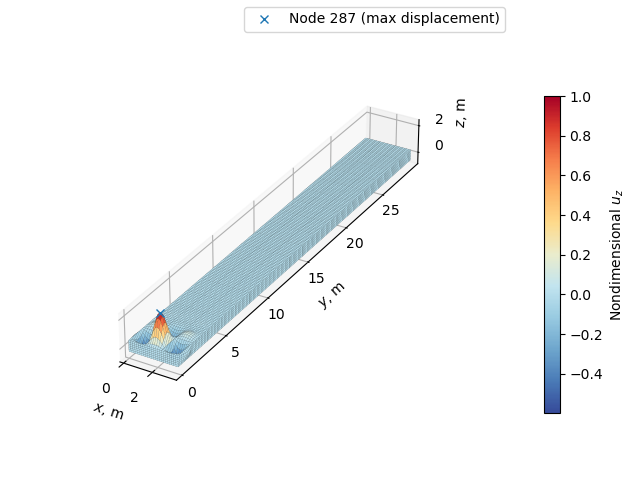

In [16]:
%matplotlib widget

import matplotlib.pyplot as plt  # import matplotlib library

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 70  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(0, .14))  # move colorbar upwards

# Read op2 file of linear buckling analysis
sol_105_op2 = linear_problem['sol_105.op2']

# Find node where max displacement occurs
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[max_displacement_index, 0]
local_displacement_node_ids = [max_displacement_node_id]  # initialize list of node ids to plot local displacements

# Plot buckling mode
amplification_factor = 2  # amplification factor for displacements
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=SECOND_SUBCASE_ID,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Plot node
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz*1e-3 + sol_105_op2.eigenvectors[
    SECOND_SUBCASE_ID].data[0, max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x',
        label=f"Node {max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend()

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

Now we set up the optimization problem by defining the default input values of the `Sol105Comp` component, by selecting the COBYLA algorithm as optimizer, and by defining the design variable, objective and constraints together with their bounds and scaling factors.

In [17]:
# Set default input values of sol_105 component
linear_problem.model.set_input_defaults('interp.t_cp', initial_thickness_vector)
linear_problem.model.set_input_defaults('sol_105.run_flag', False)

# Choose optimizer
linear_problem.driver = om.ScipyOptimizeDriver()
linear_problem.driver.options['optimizer'] = 'COBYLA'
linear_problem.driver.options['tol'] = 1e-3

# Add design variable, objective and constraints
thickness_bounds = [1., 20.]  # [mm]
linear_problem.model.add_design_var('interp.t_cp', lower=thickness_bounds[0], upper=thickness_bounds[1], ref0=thickness_bounds[0], ref=t0)  # scale thickness so that the lower bound is 0 and initial value is 1
linear_problem.model.add_objective('sol_105.mass', ref0=mass_0/2, ref=mass_0)  # scale mass so that half of the initial mass is 0 and the initial mass is 1
linear_problem.model.add_constraint('sol_105.ks_buckling', upper=0.)  # KS function for buckling load factor is not scaled because buckling load factor is already a ratio
linear_problem.model.add_constraint('sol_105.ks_stress', upper=0., ref=np.abs(ks_stress_0))  # scale KS function for stresses so that the initial value is 1

Before running the optimization, we are going to create a recorder and attach it to our `Problem` object. This will allow us to save the values of the design variable, objective and constraints at each iteration of the optimization.

In [18]:
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, 'sol_105_optimization.sql')
recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
linear_problem.driver.add_recorder(recorder)  # attach recorder to the driver

Finally, we can run the optimization calling the method `run_driver` of our `Problem` object.

In [19]:
linear_problem.setup()  # resetup problem
linear_problem.set_solver_print(0)  # disable solver output
linear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']  # print design variables, constraints and objectives
if False:  # set True or False to run optimization or not
    linear_problem.run_driver()  # run optimization
linear_problem.cleanup()  # clean up problem

Let's plot the convergence history of the optimization.

Mass variation: -21.71 %
Final thickness vector [mm]:
[8.1 4. ]
Final KS value of buckling load factor: 0.00
Final KS value for stress: -400.03 MPa


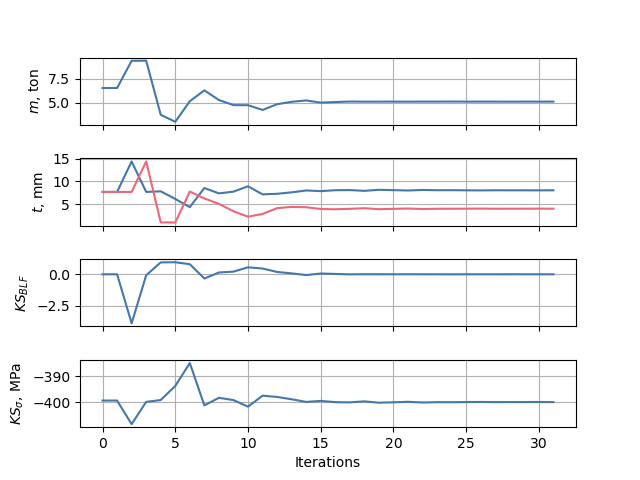

In [20]:
import tol_colors as tc  # package for colorblind-friendly colors

plt.rc("axes", prop_cycle=plt.cycler("color", list(tc.tol_cset("bright"))))  # set default color cycle to TOL bright
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]  # get default color cycle
UNSTABLE_COLOR = colors[1]  # red
del colors[1]  # delete red from list of colors

# Instantiate CaseReader object
cr = om.CaseReader(recorder_filepath)

# Get driver cases (do not recurse to system/solver cases) - driver cases represent the snapshots of all the variable values, metadata, and options of the model
driver_cases = cr.get_cases('driver', recurse=False)

# Retrieve the optimization history in terms of objective, design variable and constraints
keys = ['sol_105.mass', 'interp.t_cp', 'sol_105.ks_buckling', 'sol_105.ks_stress']  # keys of the functions to retrieve
histories = {key: np.array([case[key] for case in driver_cases]) for key in keys}  # retrieve histories of the functions

# Print mass percentage variation w.r.t. initial design and final value of thickness and constraints
mass_percentage_variation = (histories['sol_105.mass'][-1, 0]/mass_0 - 1)*100
print(f"""Mass variation: {mass_percentage_variation:.2f} %
Final thickness vector [mm]:""")
print(histories['interp.t_cp'][-1])
print(f"""Final KS value of buckling load factor: {histories['sol_105.ks_buckling'][-1, 0]:.2f}
Final KS value for stress: {histories['sol_105.ks_stress'][-1, 0]:.2f} MPa""")

# Create figure with five subplots sharing the x-axis
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

# Plot mass history
iterations_array = np.arange(len(histories['sol_105.mass']))
ax1.plot(iterations_array, histories['sol_105.mass'])
ax1.set(ylabel="$m$, ton")
ax1.grid()

# Plot thickness history
ax2.plot(iterations_array, histories['interp.t_cp'])
ax2.set(ylabel="$t$, mm")
ax2.grid()

# Plot nonlinear structural stability KS function history
ax3.plot(iterations_array, histories['sol_105.ks_buckling'])
ax3.set(ylabel="$KS_{BLF}$")
ax3.grid()

# Plot stress KS function history
ax4.plot(iterations_array, histories['sol_105.ks_stress'])
ax4.set(xlabel="Iterations", ylabel="$KS_{\sigma}$, MPa")
ax4.grid()

# Show plot
plt.show()

Visualize linear buckling of the optimized design.

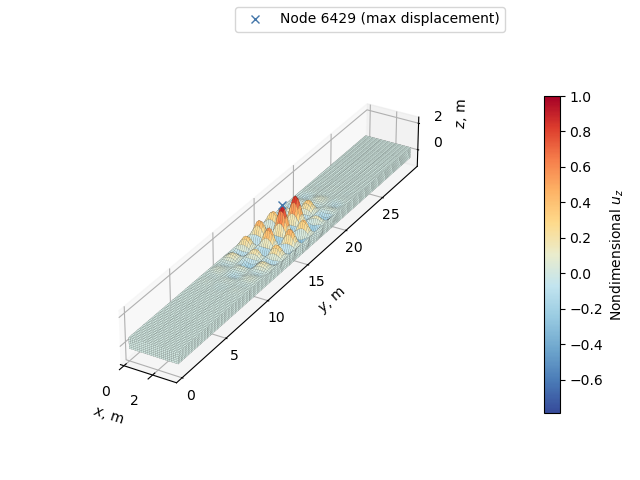

In [21]:
from pyNastran.op2.op2 import read_op2  # pyNastran function to read op2 files

# Read op2 file of linear buckling analysis
sol_105_op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, SOL_105_INPUT_NAME + '.op2')
sol_105_op2 = read_op2(op2_filename=sol_105_op2_filepath, load_geometry=True, debug=None)

# Find node where max displacement occurs
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[max_displacement_index, 0]
local_displacement_node_ids.append(max_displacement_node_id)  # add node id to list of node ids to plot local displacements

# Plot buckling mode
amplification_factor = 2  # amplification factor for displacements
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=SECOND_SUBCASE_ID,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Plot node
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz*1e-3 + sol_105_op2.eigenvectors[
    SECOND_SUBCASE_ID].data[0, max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x',
        label=f"Node {max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend()

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

What is the nonlinear response of the optimized design?

In [22]:
SOL_106_INPUT_NAME = 'box_beam_sol_106'  # default name of the bdf file for the nonlinear analysis
DEFAULT_UPPER_EIGENVALUE = 100.  # default upper bound for eigenvalues of tangent stiffness matrix [N/mm] - set to 10^5 N/m

class Sol106Comp(om.ExplicitComponent):
    """
    A component for evaluating the objective and constraints value of the box beam model using SOL 106.

    This component takes as input the wall thickness of the box beam and evaluates the mass of the model.
    It also calculates the value of the nonlinear structural stability, strength and load constraint.

    Attributes
    ----------
    options : dict
        A dictionary of options for the component.

    Methods
    -------
    initialize()
        Declare options for the component.
    setup()
        Define the component's inputs and outputs.
    setup_partials()
        Declare partial derivatives for the component.
    compute(inputs, outputs, discrete_inputs, discrete_outputs)
        Run SOL 106 and calculate output functions.
    compute_ks_function(g, rho=100, upper=0, lower_flag=False)
        Compute the value of the KS function for a given array of constraints.
    """

    def initialize(self):
        """
        Declare options for the component.

        Options
        -------
        bdf_object : BDF
            The BDF object representing the model.
        """
        self.options.declare('bdf_object', types=BDF)
        self.options.declare('upper_eig', types=float, default=DEFAULT_UPPER_EIGENVALUE)  # default upper bound for eigenvalues of tangent stiffness matrix [N/mm] - set to 10^4 N/m

    def setup(self):
        """
        Define the component's inputs and outputs.

        Inputs
        ------
        t : float
            Wall thickness.
        input_name : str, discrete
            Name of the input for the analysis.
        run_flag : bool, discrete
            Flag to indicate if the analysis should be run.

        Outputs
        -------
        mass : float
            Mass of the model.
        ks_stress : float
            Von Mises stress aggregated with KS function.
        ks_stability : float
            Lowest eigenvalues of the tangent stiffness matrix aggregated with KS function.
        applied_load : float
            Final applied load in the analysis.
        op2 : OP2, discrete
            OP2 object of the analysis.
        """
        self.add_input('t', shape_by_conn=True)
        self.add_discrete_input('input_name', val=SOL_106_INPUT_NAME)
        self.add_discrete_input('run_flag', val=True)
        self.add_output('mass')
        self.add_output('ks_stress')
        self.add_output('ks_stability')
        self.add_output('applied_load')
        self.add_discrete_output('op2', val=None)

    def setup_partials(self):
        """
        Declare partial derivatives for the component using finite difference method.
        """
        # Finite difference all partials
        self.declare_partials('*', '*', method='fd', step=1e-6)

    def compute(self, inputs, outputs, discrete_inputs, discrete_outputs):
        """
        Assign wall thickness value, run SOL 106 and calculate output functions.

        Parameters
        ----------
        inputs : dict
            Dictionary containing the input values.
        outputs : dict
            Dictionary containing the output values.
        discrete_inputs : dict
            Dictionary containing the discrete input values.
        discrete_outputs : dict
            Dictionary containing the discrete output values.
        """
        # Assign component options
        bdf_object = self.options['bdf_object']
        upper_eig = self.options['upper_eig']
        # Assign thicknesses to PSHELL cards
        for i, pid in enumerate(bdf_object.properties):
            bdf_object.properties[pid].t = inputs['t'][0, i]
            bdf_object.properties[pid].z1 = -inputs['t'][0, i]/2
            bdf_object.properties[pid].z2 = inputs['t'][0, i]/2
        # Calculate mass
        outputs['mass'] = mass_properties(bdf_object)[0]
        # Run SOL 106 and return OP2 object as discrete output
        input_name = discrete_inputs['input_name']
        run_flag = discrete_inputs['run_flag']
        sol_106_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=bdf_object.__deepcopy__({}),
                                                                                          method_set_id=METHOD_SET_ID,
                                                                                          no_eigenvalues=NO_EIGENVALUES,
                                                                                          analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                                                                                          input_name=input_name, upper_eig=DEFAULT_UPPER_EIGENVALUE,
                                                                                          run_flag=run_flag)
        discrete_outputs['op2'] = sol_106_op2
        # Read eigenvalues of tangent stiffness matrix and aggregate with KS function
        f06_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
        eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)  # read eigenvalues from f06 files
        outputs['ks_stability'] = self.compute_ks_function(eigenvalues[~np.isnan(eigenvalues)].flatten()*1e3, lower_flag=True)  # eigenvalues are converted from N/mm to N/m
        # Find von mises stresses and aggregate with KS function
        stresses = sol_106_op2.nonlinear_cquad4_stress[FIRST_SUBCASE_ID].data[-1, :, 5]
        outputs['ks_stress'] = self.compute_ks_function(stresses, upper=SIGMA_Y)
        # Find final applied load in the analysis
        _, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2)
        outputs['applied_load'] = applied_loads[FIRST_SUBCASE_ID][-1, Z_AXIS_INDEX]  # read load along z-axis at last converged iteration
    
    @staticmethod
    def compute_ks_function(g, rho=100, upper=0, lower_flag=False):
        """
        Compute the value of the KS function for the given array of constraints.

        Parameters
        ----------
        g : ndarray
            Array of constraint values. By default negative means satisfied and positive means violated. Behavior is modified with upper and lower_flag.
        rho : float, optional
            Constraint aggregation factor. Default is 100.
        upper : float, optional
            Upper bound for the constraints. If lower_flag is True, then this is the lower bound. Default is 0.
        lower_flag : bool, optional
            Flag to indicate if the constraints are lower-bounded. Default is False.

        Returns
        -------
        float
            Value of KS function.
        """
        con_val = g - upper  # subtract upper bound
        if lower_flag:
            con_val = -con_val  # negate if constraint is lower-bounded
        g_max = np.max(np.atleast_2d(con_val), axis=-1)[:, np.newaxis]  # find maximum constraint value
        g_diff = con_val - g_max  # subtract maximum constraint value
        exponents = np.exp(rho * g_diff)  # exponentiate
        summation = np.sum(exponents, axis=-1)[:, np.newaxis]  # sum exponentiated values
        KS = g_max + 1.0 / rho * np.log(summation)  # compute KS function
        return KS

In [23]:
class BoxBeamNonlinearGroup(om.Group):
    """
    A group representing a system setup for the nonlinear analysis and optimization of a box beam model.

    This group is designed for the analysis and the mass minimization of a box beam model, 
    subject to KS aggregated von Mises stress and structural stability constraints. 
    It incorporates the Sol106Comp component to achieve this.

    Attributes
    ----------
    options : dict
        A dictionary of options for the group.

    Methods
    -------
    initialize()
        Declare options for the group.
    setup()
        Define the group's components and their interconnections.
    """

    def initialize(self):
        """
        Declare options for the group.

        Options
        -------
        bdf_object : BDF
            The BDF object representing the box beam model.
        """
        self.options.declare('bdf_object', BDF)

    def setup(self):
        """
        Define the group's components and their interconnections.

        The method sets up the Sol106Comp component within the group using the provided box beam model.
        """
        bdf_object = self.options['bdf_object']  # assign group options
        comp = Sol106Comp(bdf_object=bdf_object)  # create SOL 106 component
        self.add_subsystem('sol_106', comp)  # add SOL 106 component to the group

Set up nonlinear analysis parameters.

In [24]:
box_beam_bdf.case_control_deck.subcases[0].params['NLSTRESS'] = box_beam_bdf.case_control_deck.subcases[0].params.pop('STRESS')  # change stress output to nonlinear stresses
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, ninc=100, max_iter=3, conv='PU', eps_p=1e-4, eps_u=1e-4, max_bisect=20,
                                         minalr=1e-5, maxalr=1.0001, desiter=3, maxinc=2000)
load_set_id = FORCE_SET_ID + 1
box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[2.], load_ids=[FORCE_SET_ID])
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=FIRST_SUBCASE_ID, load_set_id=load_set_id)

Set up OpenMDAO problem and run nonlinear analysis of linear-optimized model.

In [25]:
box_beam_nonlinear = BoxBeamNonlinearGroup(bdf_object=box_beam_bdf.__deepcopy__({}))
box_beam_nonlinear.add_subsystem('interp', interp_comp)  # add spline component to the group
box_beam_nonlinear.connect('interp.t_val', 'sol_106.t')  # connect spline component output to the SOL 105 component input
nonlinear_problem = om.Problem(model=box_beam_nonlinear)
nonlinear_problem.setup()
nonlinear_problem.set_val('interp.t_cp', histories['interp.t_cp'][-1])
input_name = "linear_opt_sol_106"
nonlinear_problem.set_val('sol_106.input_name', input_name)
nonlinear_problem.set_val('sol_106.run_flag', False)
nonlinear_problem.run_model()

Nastran job linear_opt_sol_106.bdf completed
Wall time: 15949.0 s


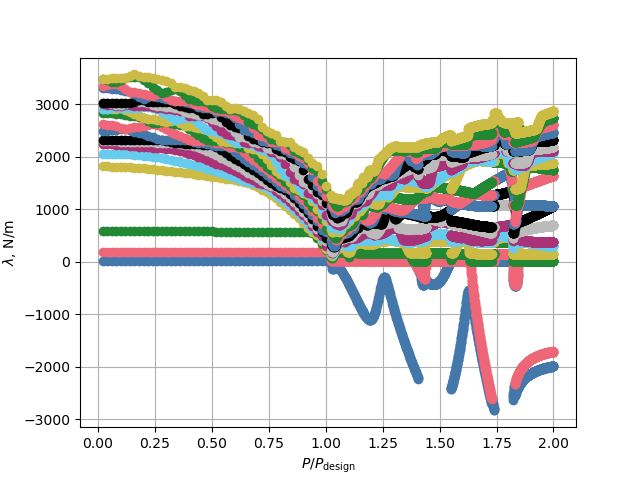

In [26]:
# Retrieve OP2 object of nonlinear analysis
sol_106_op2 = nonlinear_problem['sol_106.op2']

# Read load and displacement history of benchmark analysis from op2 file
_, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2)

# Read eigenvalues of tangent stiffness matrix
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Plot eigenvalues vs applied load
_, ax = plt.subplots()
ax.plot(applied_loads[FIRST_SUBCASE_ID][:, Z_AXIS_INDEX]/design_load, eigenvalues.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel("$P/P_\mathrm{design}$")
ax.grid(visible=True)
plt.show()

Reanalyze capping max positive eigenvalue to 2200 N/m and calculating the eigenvectors.

In [27]:
linear_opt_box_beam_bdf = nonlinear_problem.model.sol_106.options['bdf_object']
upper_eigenvalue = 2200.*1e-3  # upper bound for eigenvalues [N/mm]
input_name = f"linear_opt_sol_106_upper_eig{upper_eigenvalue:.0f}"
sol_106_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=linear_opt_box_beam_bdf.__deepcopy__({}),
                                                                                  method_set_id=METHOD_SET_ID, no_eigenvalues=NO_EIGENVALUES,
                                                                                  analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                                                                                  input_name=input_name, upper_eig=upper_eigenvalue,
                                                                                  eigenvectors_flag=True, run_flag=False)

Nastran job linear_opt_sol_106_upper_eig2.bdf completed
Wall time: 14826.0 s


Plot eigenvalues

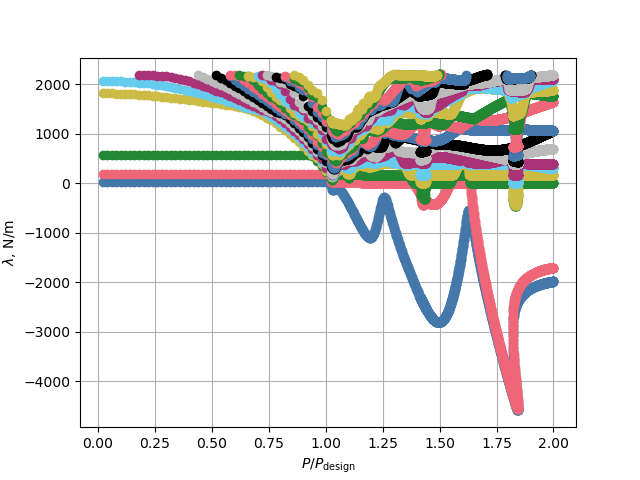

In [28]:
# Read load and displacement history of benchmark analysis from op2 file
_, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2)
applied_loads_key = next(iter(applied_loads))

# Assemble array of eigenvalues of tangent stiffness matrix
eigenvectors_key = next(iter(sol_106_op2.eigenvectors))
sequence_starts = np.where(sol_106_op2.eigenvectors[eigenvectors_key].lsdvmns == 1)[0]
sequence_ends = np.roll(sequence_starts, -1)
sequence_ends[-1] = len(sol_106_op2.eigenvectors[eigenvectors_key].lsdvmns)  # Setting the end of the last sequence to the end of the array
eigenvalues = np.column_stack([np.pad(sol_106_op2.eigenvectors[eigenvectors_key].eigrs[start:end], (0, NO_EIGENVALUES - (end - start)),
                                      mode='constant', constant_values=np.nan) for start, end in zip(sequence_starts, sequence_ends)])

# Plot eigenvalues vs applied load
_, ax = plt.subplots()
ax.plot(applied_loads[applied_loads_key][:, Z_AXIS_INDEX]/design_load, eigenvalues.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel("$P/P_\mathrm{design}$")
ax.grid(visible=True)
plt.show()

Plot eigenvector of first eigenvalue going negative.

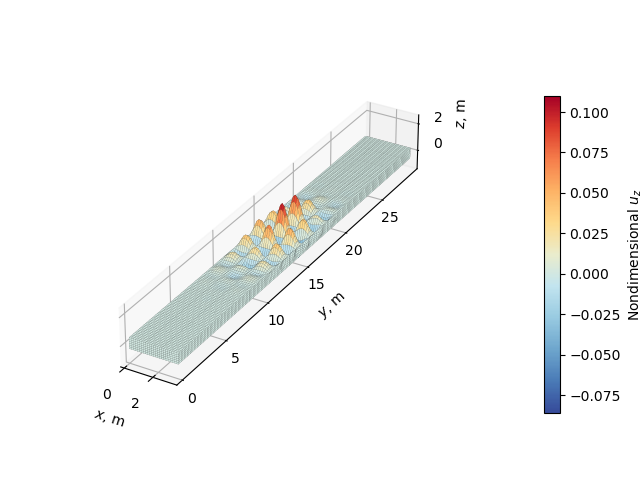

In [29]:
first_negative_index = np.argmax(np.array(sol_106_op2.eigenvectors[eigenvectors_key].eigrs) < 0)

# Plot buckling mode
amplification_factor = 20  # amplification factor for displacements
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_106_op2, subcase_id=eigenvectors_key, mode_number=first_negative_index+1,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

Rerun analysis with finer resolution.

Nastran job linear_opt_sol_106_epsp1e-5.bdf completed
Wall time: 18348.0 s


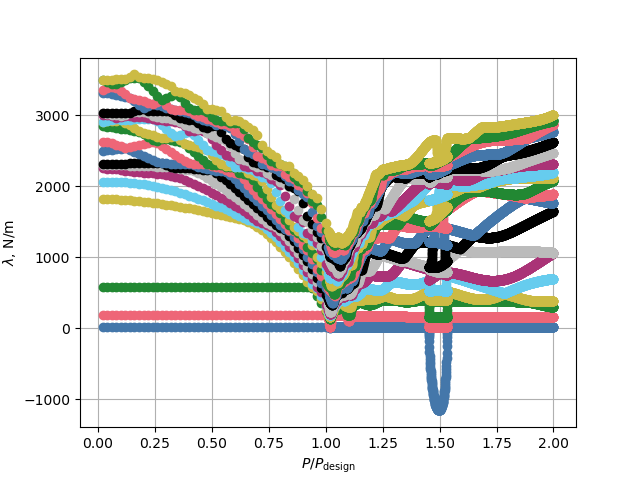

In [30]:
linear_opt_box_beam_bdf.nlparms[1].eps_p = 1e-5  # set tighter convergence tolerance for load
linear_opt_box_beam_bdf.nlparms[1].eps_u = 1e-5  # set tighter convergence tolerance for displacement
linear_opt_box_beam_bdf.nlpcis[1].mxinc = 2000  # increase maximum number of increments
input_name = 'linear_opt_sol_106_epsp1e-5'
sol_106_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=linear_opt_box_beam_bdf.__deepcopy__({}),
                                                                                  method_set_id=METHOD_SET_ID, no_eigenvalues=NO_EIGENVALUES,
                                                                                  analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                                                                                  input_name=input_name, upper_eig=DEFAULT_UPPER_EIGENVALUE,
                                                                                  run_flag=False)

# Read load and displacement history of benchmark analysis from op2 file
_, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2)

# Read eigenvalues of tangent stiffness matrix
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Plot eigenvalues vs applied load
_, ax = plt.subplots()
ax.plot(applied_loads[FIRST_SUBCASE_ID][:, Z_AXIS_INDEX]/design_load, eigenvalues.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel("$P/P_\mathrm{design}$")
ax.grid(visible=True)
plt.show()

Set nonlinear analysis parameters for optimization and verify convergence.

In [31]:
nonlinear_problem.model.sol_106.options['bdf_object'].nlparms[1].ninc = 10
nonlinear_problem.model.sol_106.options['bdf_object'].nlpcis[1].maxalr = 4.
nonlinear_problem.model.sol_106.options['bdf_object'].nlpcis[1].mxinc = 400
nonlinear_problem.model.sol_106.options['bdf_object'].load_combinations[load_set_id][0].scale_factors[0] = 1.  # reset load factor

Change applied load to design load and calculate objective and constraints of starting point.

In [32]:
input_name = 'nonlinear_opt_sol_106_start'
nonlinear_problem.set_val('sol_106.input_name', input_name)
nonlinear_problem.set_val('sol_106.run_flag', False)
nonlinear_problem.run_model()
mass_0 = nonlinear_problem['sol_106.mass'][0]
ks_stability_0 = nonlinear_problem["sol_106.ks_stability"][0]
ks_stress_0 = nonlinear_problem["sol_106.ks_stress"][0]
print(f"""Initial mass: {mass_0*1e3:.0f} kg
Initial KS value for stability: {ks_stability_0:.1f} N/m
Initial KS value for stress: {ks_stress_0:.0f} MPa""")

Nastran job nonlinear_opt_sol_106_start.bdf completed
Wall time: 191.0 s


Initial mass: 5104 kg
Initial KS value for stability: -19.3 N/m
Initial KS value for stress: -400 MPa


Set up and run optimization.

In [33]:
# Set default input values of sol_106 component
nonlinear_problem.model.set_input_defaults('interp.t_cp', histories['interp.t_cp'][-1])
nonlinear_problem.model.set_input_defaults('sol_106.input_name', 'nonlinear_opt_sol_106')
nonlinear_problem.model.set_input_defaults('sol_106.run_flag', False)

# Choose optimizer
nonlinear_problem.driver = om.ScipyOptimizeDriver()
nonlinear_problem.driver.options['optimizer'] = 'COBYLA'
nonlinear_problem.driver.options['tol'] = 1e-3

# Add design variable, objective and constraints
nonlinear_problem.model.add_design_var('interp.t_cp', lower=thickness_bounds[0], upper=thickness_bounds[1], ref0=thickness_bounds[0], ref=t0)  # scale thickness so that the lower bound is 0 and initial value is 1
nonlinear_problem.model.add_objective('sol_106.mass', ref0=mass_0/2, ref=mass_0)  # scale mass so that half of the initial mass is 0 and the initial mass is 1
nonlinear_problem.model.add_constraint('sol_106.ks_stability', upper=0., ref=np.abs(ks_stability_0))  # scale KS function for nonlinear structural stability so that the initial value is 1
nonlinear_problem.model.add_constraint('sol_106.ks_stress', upper=0., ref=np.abs(ks_stress_0))  # scale KS function for stresses so that the initial value is 1
nonlinear_problem.model.add_constraint('sol_106.applied_load', lower=design_load*.99, ref=design_load)  # scale applied load so that design

In [34]:
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, 'sol_106_optimization.sql')
recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
nonlinear_problem.driver.add_recorder(recorder)  # attach recorder to the driver

In [35]:
nonlinear_problem.setup()  # re-setup problem
nonlinear_problem.set_solver_print(0)  # disable solver output
nonlinear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']  # print design variables, constraints and objectives
if False:  # set True or False to run optimization or not
    nonlinear_problem.run_driver()  # run optimization
nonlinear_problem.cleanup()  # clean up problem

Plot optimization history.

Mass variation: -26.5 %
Final thickness vector [mm]:
[7.9 1. ]
Final KS value of nonlinear structural stability: 30.87 N/m
Final KS value for stress: -379 MPa


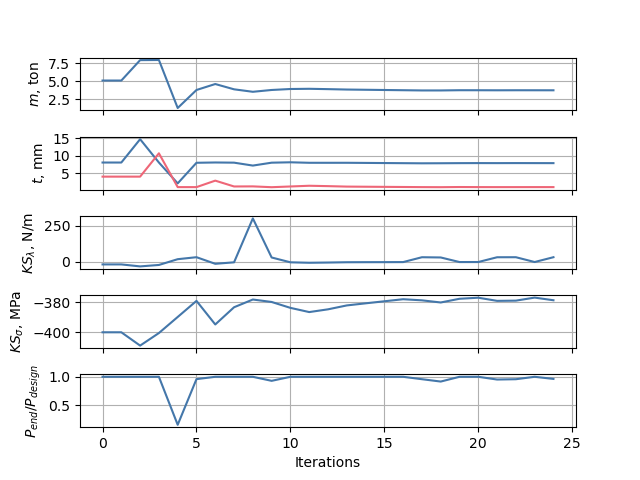

In [36]:
# Instantiate CaseReader object
cr = om.CaseReader(recorder_filepath)

# Get driver cases (do not recurse to system/solver cases) - driver cases represent the snapshots of all the variable values, metadata, and options of the model
driver_cases = cr.get_cases('driver', recurse=False)

# Retrieve the optimization history in terms of objective, design variable and constraints
keys = ['sol_106.mass', 'interp.t_cp', 'sol_106.ks_stability', 'sol_106.ks_stress', 'sol_106.applied_load']  # keys of the functions to retrieve
histories = {key: np.array([case[key] for case in driver_cases]) for key in keys}  # retrieve histories of the functions

# Print mass percentage variation w.r.t. initial design and final value of thickness and constraints
mass_percentage_variation = (histories['sol_106.mass'][-1, 0]/mass_0 - 1)*100
print(f"""Mass variation: {mass_percentage_variation:.1f} %
Final thickness vector [mm]:""")
print(histories['interp.t_cp'][-1])
print(f"""Final KS value of nonlinear structural stability: {histories["sol_106.ks_stability"][-1, 0]:.2f} N/m
Final KS value for stress: {histories['sol_106.ks_stress'][-1, 0]:.0f} MPa""")

# Create figure with five subplots sharing the x-axis
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

# Plot mass history
iterations_array = np.arange(len(histories['sol_106.mass']))
ax1.plot(iterations_array, histories['sol_106.mass'])
ax1.set(ylabel="$m$, ton")
ax1.grid()

# Plot thickness history
ax2.plot(iterations_array, histories['interp.t_cp'])
ax2.set(ylabel="$t$, mm")
ax2.grid()

# Plot nonlinear structural stability KS function history
ax3.plot(iterations_array, histories['sol_106.ks_stability'])
ax3.set(ylabel="$KS_{\lambda}$, N/m")
ax3.grid()

# Plot stress KS function history
ax4.plot(iterations_array, histories['sol_106.ks_stress'])
ax4.set(ylabel="$KS_{\sigma}$, MPa")
ax4.grid()

# Plot applied load history
ax5.plot(iterations_array, histories['sol_106.applied_load']/design_load)
ax5.set(xlabel='Iterations', ylabel="$P_{end}/P_{design}$")
ax5.grid()

# Show plot
plt.show()

Find linear buckling of nonlinear optimized design.

Nastran job nonlinear_opt_sol_105.bdf completed
Wall time: 15.0 s


P_sol105/P_design = 0.05
Buckling mode:


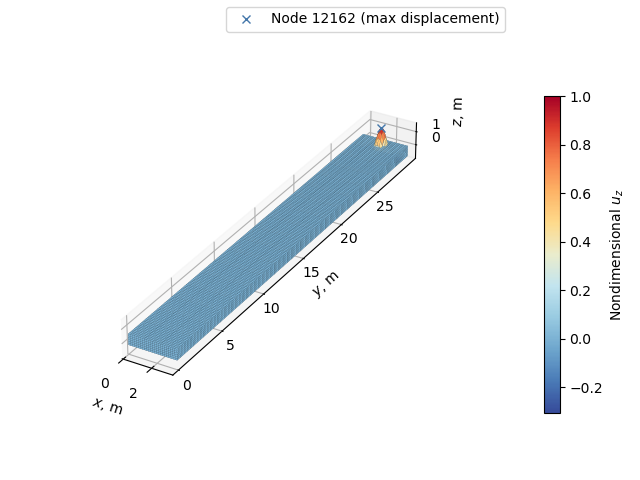

In [37]:
linear_problem.setup()  # re-setup problem
linear_problem.set_val('interp.t_cp', histories['interp.t_cp'][-1])
input_name = 'nonlinear_opt_sol_105'
linear_problem.set_val('sol_105.input_name', input_name)
linear_problem.set_val('sol_105.run_flag', False)
linear_problem.run_model()

# Read op2 file of linear buckling analysis
sol_105_op2 = linear_problem['sol_105.op2']

# Find buckling load
buckling_load_factor = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
print(f"P_sol105/P_design = {buckling_load_factor:.2f}")

# Find node where max displacement occurs
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[max_displacement_index, 0]
local_displacement_node_ids.append(max_displacement_node_id)  # add node to list of nodes to plot displacement history

# Plot buckling mode
amplification_factor = 2  # amplification factor for displacements
print("Buckling mode:")
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=SECOND_SUBCASE_ID,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m
# Plot node
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz*1e-3 + sol_105_op2.eigenvectors[
    SECOND_SUBCASE_ID].data[0, max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x',
        label=f"Node {max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend()

# Adjust plot and show
adjust_3d_plot(ax, cbar)
# ax.view_init(-30, 0)
plt.show()

Plot load-displacement diagram of nonlinearly optimized design.

In [38]:
# Define function to plot load-displacement diagram segment by segment
def plot_segments(eigvals, axes, disp, loads, marker, color):
    negative_eigenvalues_mask = (eigvals < 0).any(axis=0)
    unstable_segments = []  # list to store indices of unstable segments
    stable_segments = []  # list to store indices of stable segments
    # Loop through the negative_eigenvalues_mask to identify and plot segments
    for i, is_negative in enumerate(negative_eigenvalues_mask):
        if is_negative:
            if stable_segments:
                # Plot the stable segment if there was one before
                stable_segments.append(i)  # make the stable segment finish at the first point of the unstable segment
                axes.plot(disp[stable_segments], loads[stable_segments], marker + "-", color=color)
                stable_segments = []  # reset the stable segment indices
            unstable_segments.append(i)  # add the current index to the unstable segment, this will overwrite the blue point with a red one
        else:
            if unstable_segments:
                # Plot the unstable segment if there was one before
                unstable_segments.append(i)  # make the unstable segment finish at the first point of the stable segment
                axes.plot(disp[unstable_segments], loads[unstable_segments], marker + "--", color=UNSTABLE_COLOR)
                unstable_segments = []  # reset the unstable segment indices
            stable_segments.append(i)  # add the current index to the stable segment, this will overwrite the red point with a blue one
    # Plot the remaining segments if any
    if stable_segments:
        axes.plot(disp[stable_segments], loads[stable_segments], marker + "-", color=color)
    if unstable_segments:
        axes.plot(disp[unstable_segments], loads[unstable_segments], marker + "--", color=UNSTABLE_COLOR)


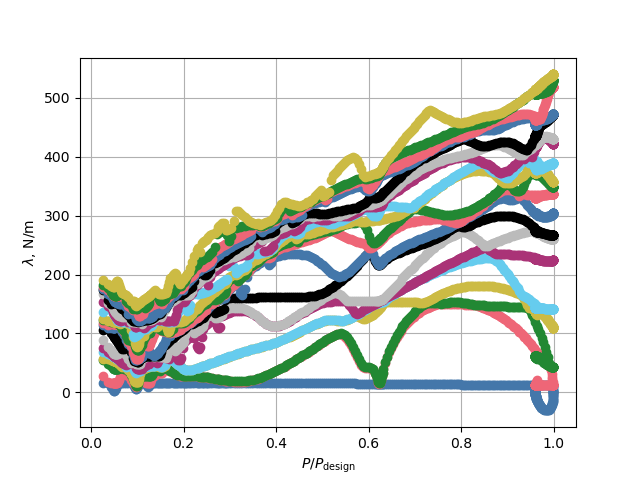

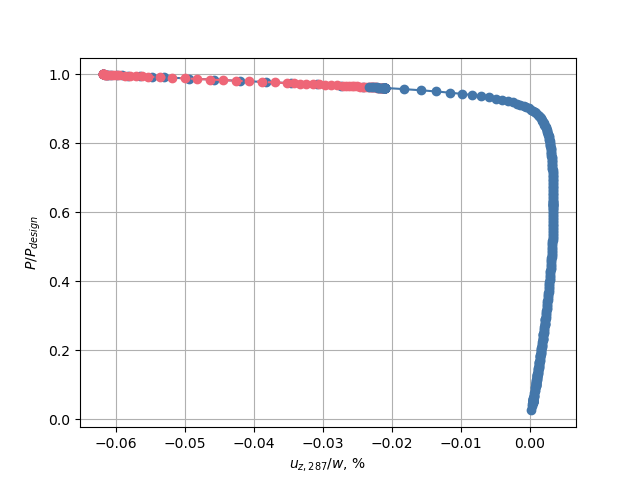

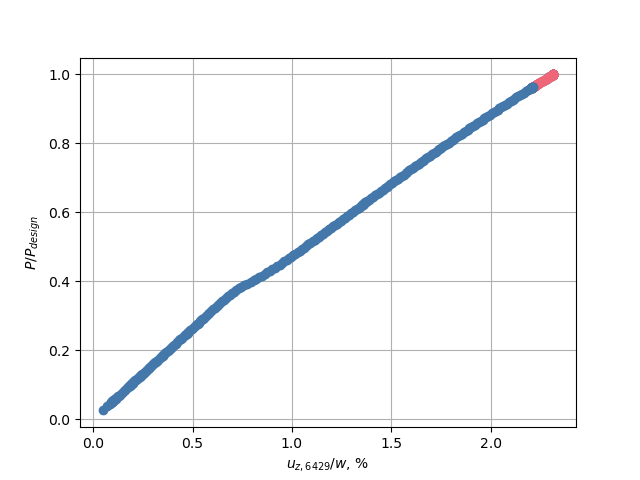

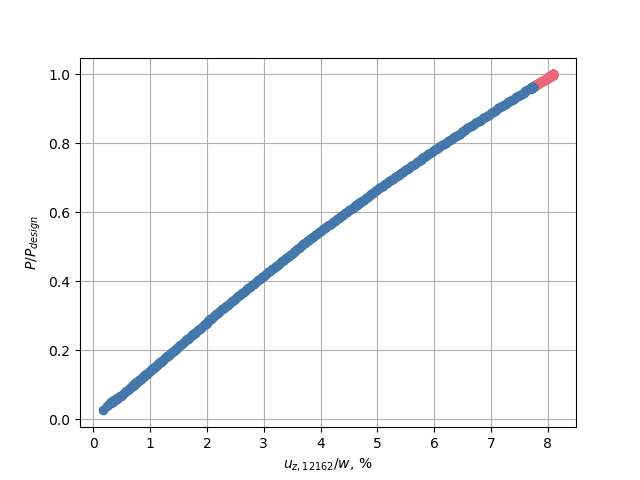

In [39]:
# Retrieve OP2 object of nonlinear analysis
sol_106_op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, SOL_106_INPUT_NAME + '.op2')
sol_106_op2 = read_op2(op2_filename=sol_106_op2_filepath, load_geometry=True, debug=None)

# Read load and displacement history of benchmark analysis from op2 file
_, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2)

# Read eigenvalues of tangent stiffness matrix
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, SOL_106_INPUT_NAME + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Plot eigenvalues vs applied load
_, ax = plt.subplots()
ax.plot(applied_loads[FIRST_SUBCASE_ID][:-1, Z_AXIS_INDEX]/design_load, eigenvalues.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel("$P/P_\mathrm{design}$")
ax.grid(visible=True)
plt.show()

# Plot load-displacement diagram for each node in local_displacement_node_ids
for node_id in local_displacement_node_ids:
    _, _, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2, displacement_node_id=node_id)
    _, ax = plt.subplots()
    plot_segments(eigenvalues, ax, local_displacements[FIRST_SUBCASE_ID][:, Z_AXIS_INDEX]/w*100, applied_loads[FIRST_SUBCASE_ID][:, Z_AXIS_INDEX]/design_load, 'o', colors[0])
    ax.set_xlabel(f"$u_{{z, {node_id:d}}}/w$, %")
    ax.set_ylabel("$P/P_{design}$")
    ax.grid(visible=True)
    plt.show()

Rerun analysis with finer arc-length step size.

In [40]:
nonlinear_problem.setup()  # re-setup problem
nonlinear_problem.model.sol_106.options['bdf_object'].nlparms[1].ninc = round(1/(buckling_load_factor/10))
nonlinear_problem.model.sol_106.options['bdf_object'].nlpcis[1].mxinc = 1000
nonlinear_problem.set_val('interp.t_cp', histories['interp.t_cp'][-1])
input_name = 'nonlinear_opt_sol_106'
nonlinear_problem.set_val('sol_106.input_name', input_name)
nonlinear_problem.set_val('sol_106.run_flag', False)
nonlinear_problem.run_model()

Nastran job nonlinear_opt_sol_106.bdf completed
Wall time: 2425.0 s


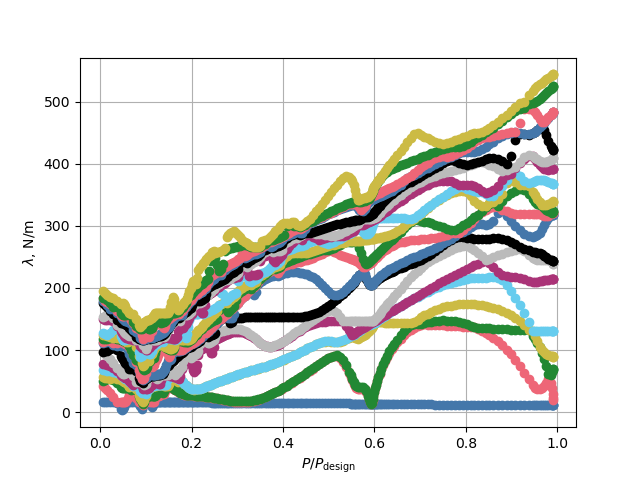

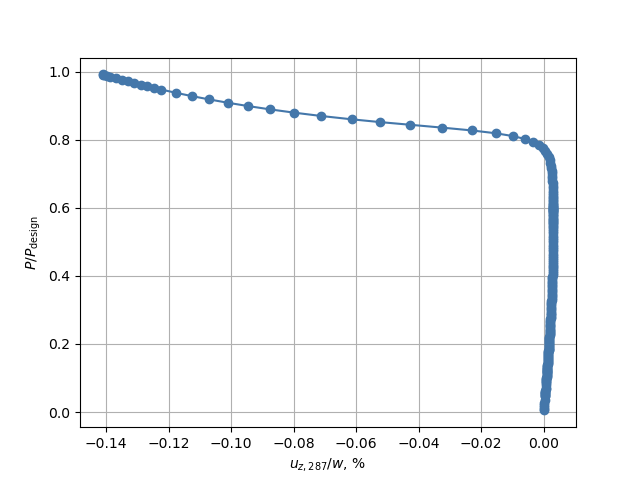

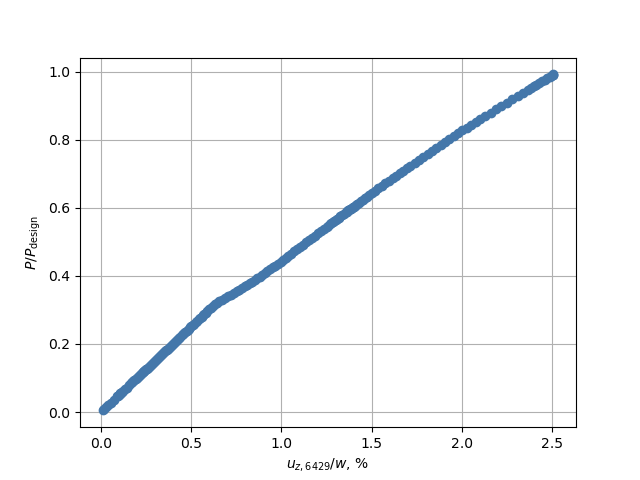

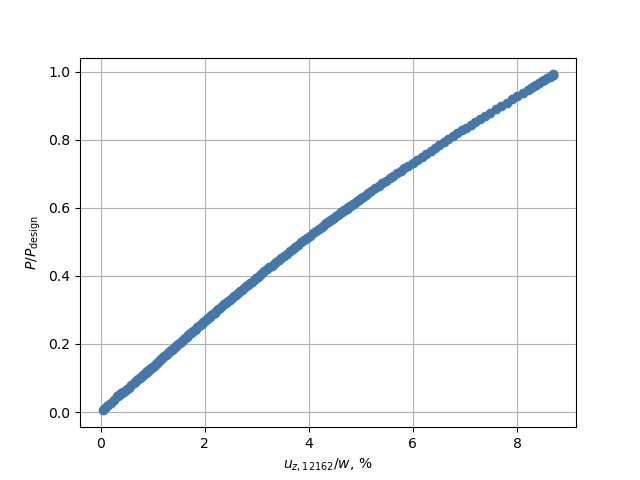

In [41]:
# Retrieve OP2 object of nonlinear analysis
sol_106_op2 = nonlinear_problem['sol_106.op2']

# Read load and displacement history of benchmark analysis from op2 file
_, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2)

# Read eigenvalues of tangent stiffness matrix
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Plot eigenvalues vs applied load
_, ax = plt.subplots()
ax.plot(applied_loads[FIRST_SUBCASE_ID][:, Z_AXIS_INDEX]/design_load, eigenvalues.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel("$P/P_\mathrm{design}$")
ax.grid(visible=True)
plt.show()

# Plot load-displacement diagram for each node in local_displacement_node_ids
for node_id in local_displacement_node_ids:
    _, _, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2, displacement_node_id=node_id)
    _, ax = plt.subplots()
    plot_segments(eigenvalues, ax, local_displacements[FIRST_SUBCASE_ID][:, Z_AXIS_INDEX]/w*100, applied_loads[FIRST_SUBCASE_ID][:, Z_AXIS_INDEX]/design_load, 'o', colors[0])
    ax.set_xlabel(f"$u_{{z, {node_id:d}}}/w$, %")
    ax.set_ylabel("$P/P_\mathrm{design}$")
    ax.grid(visible=True)
    plt.show()

Plot deformation at design load.

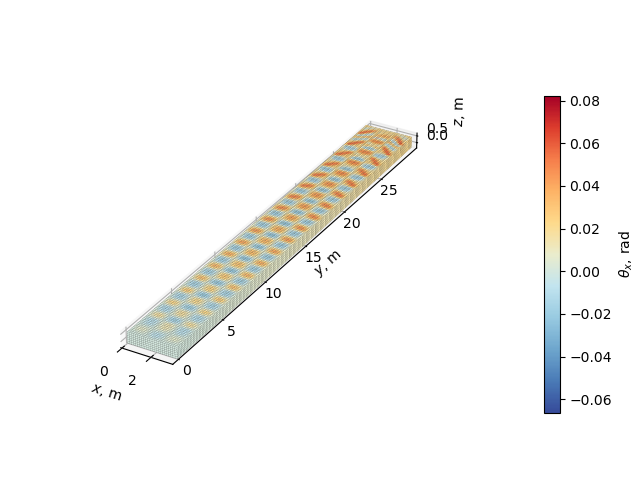

In [42]:
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2, displacement_component='rx',
                                                        colormap='sunset', length_unit='m', unit_scale_factor=1e-3)  # convert from mm to m
adjust_3d_plot(ax, cbar)
plt.show()